
Introduction

Description

In this time-series 'getting-started' competition, we are asked to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. We need a model that can predict unit sales for thousands of items sold at different stores. For this competition we have different datasets describing sales, stores, holiday data and more between 2013 and 2017 in Ecuador.

Goal

To predict the sales per product, per store for the next 16 days.

Metric

The evaluation metric used for this competition is Root-Mean-Squared-Logarithmic-Error (RMSLE). (Taking logs means that errors in predicting big salesnumbers and smaller salesnumbers will affect the result more evenly.)


In [1]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
from re import search

In [2]:
random.seed(333)
pd.options.mode.chained_assignment = None


1. Exploratory Data Analysis:
1.1 Dataframes & NAs

As a first step of the EDA we would like to know what our data looks like, and if there are any NAs in the dataset.

We have different data sets to our disposal:

    holiday_events: a list with all ecuadorian holidays and events;
    oil: a list of oilprices meant to serve as an economic indicator of Ecuador;
    stores: a dataset with information about our stores: includes city, state, type and others;
    transactions: a dataset containing the number of aggregated transactions for each store on each day;
    test: general testset of 16 days of sales we will need to predict;
    train: a huge trainset with about 4 years of data to predict our test sales data.

This notebook makes use of all datasets except for the oilprices as on the surface it didn't seem to give any improvement in the modelling results. This could potentially be added in a future update of this notebook if it does happen to be useful.


In [3]:
# Read train/test data and check colnames & NA's:

original_train = pd.read_csv('/workspaces/PracticeMachineLearning/data/store_sales_train_small.csv')
original_test = pd.read_csv('/workspaces/PracticeMachineLearning/data/store_sales_test.csv')

# Dataframe info:
print(original_train.info())

# Check NAs:
original_train.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600001 entries, 0 to 600000
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           600001 non-null  int64  
 1   date         600001 non-null  object 
 2   store_nbr    600001 non-null  int64  
 3   family       600001 non-null  object 
 4   sales        600001 non-null  float64
 5   onpromotion  600001 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 27.5+ MB
None


id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

We have ID, date, store number, (product) family, saleprice and promotion columns. Our train and test datasets have zero missing values.

In [4]:
# Find out how many stores, products and dates are in our data:

original_train['store_nbr'].unique().__len__() # 54 stores
original_train['family'].unique().__len__() # 33 products

len(original_train) / 54 / 33 # 1684 days (between 4 and 5 years)
original_train['date'].iloc[0] # 2013-01-01 is start
original_train['date'].iloc[-1] # 2017-08-15 is end

len(original_test) / 54 / 33 # 16 days
original_test['date'].iloc[0] # 2017-08-16 is test start
original_test['date'].iloc[-1] # 2017-08-31 is test end

'2017-08-31'



Our main datasets consist of:

    54 stores

    33 productgroups

We are asked to predict the sales for each productgroup (33), at each store (54) during 16 consecutive days. This means we will have to do 33 * 54 * 16 = 28512 predictions. To make this more manageable, we can create a dataframe and predictions for each individual productgroup. This means we will create 33 dataframes that each do 864 predictions.

For faster runtime and better oversight we will first create different dataframes that we then merge together through a pipeline into 33 individual product dataframes.
1.2 Visualization

Since we are going to create a dataframe per product, it is best to create a graph to see the sales evolution for each family over the years. We want the sum of sales for each month, for each year, for each family, so we aggregate accordingly.


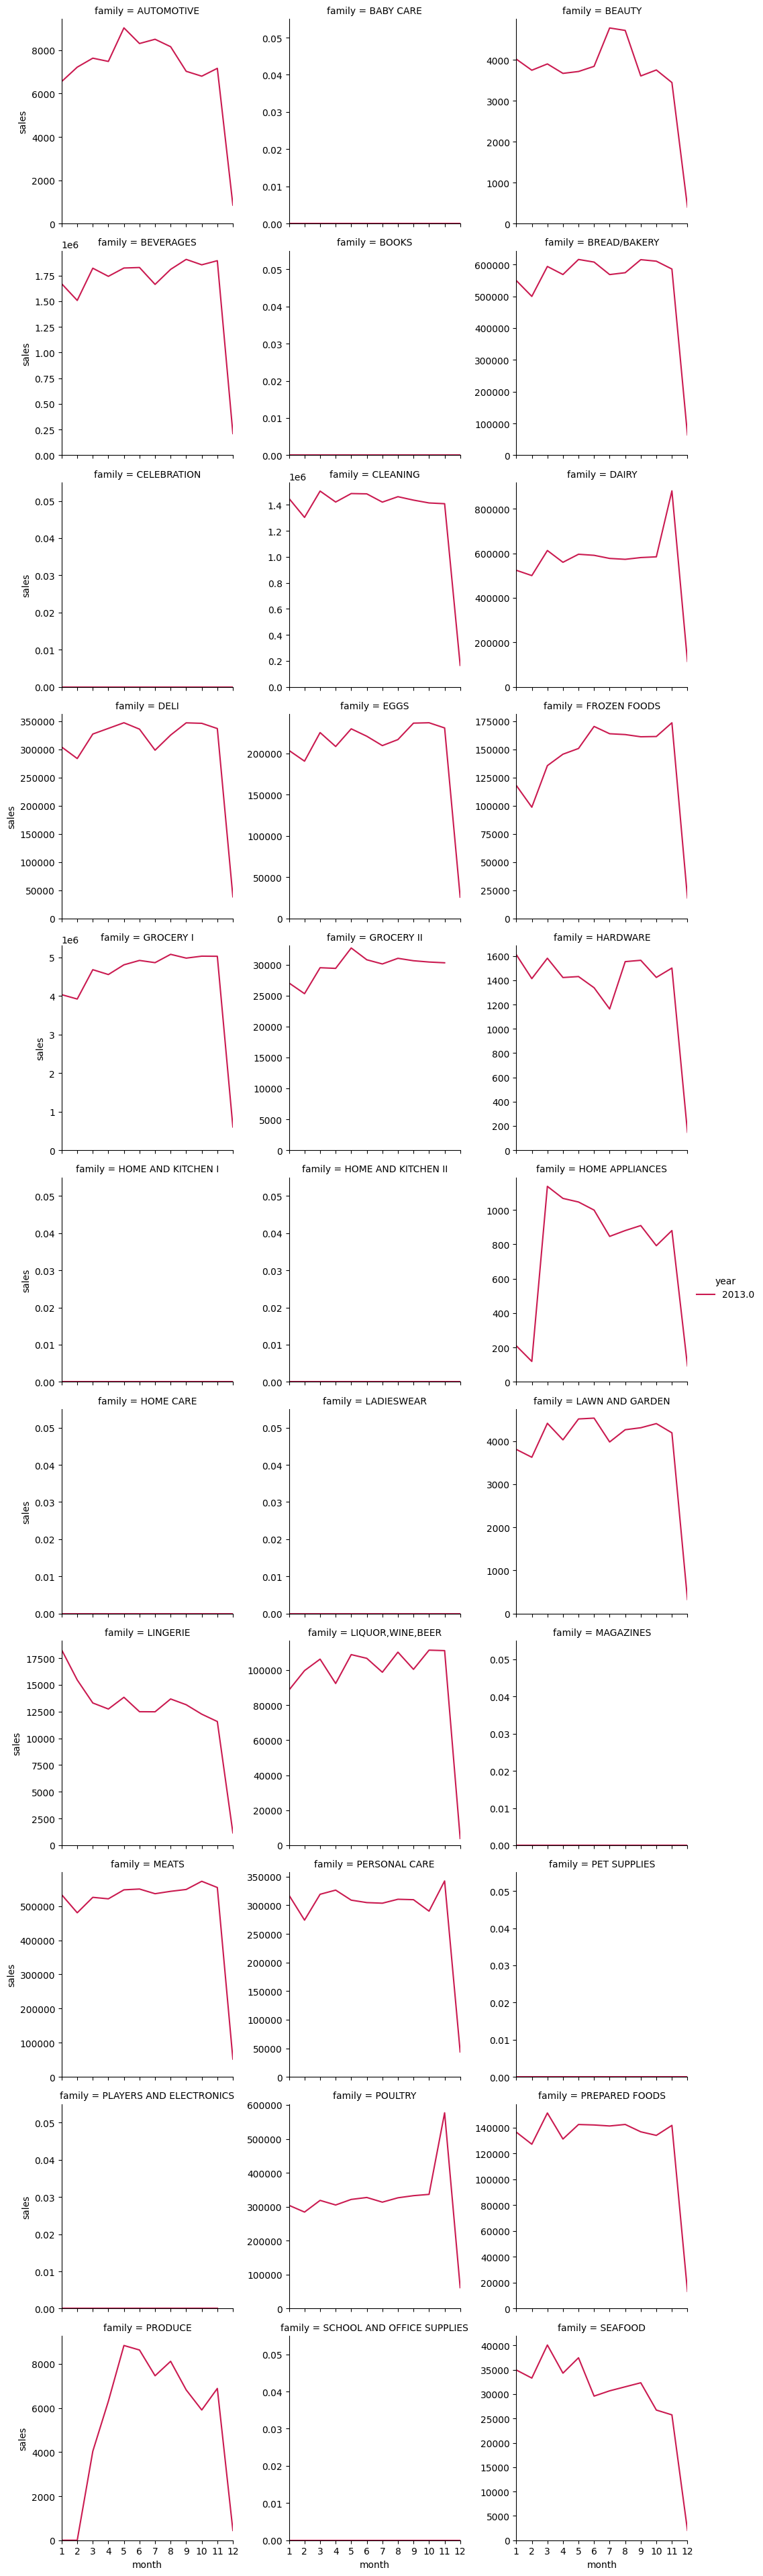

In [5]:
original_train['date'] = pd.to_datetime(original_train['date'])
original_train['year'] = original_train['date'].dt.year
original_train['month'] = original_train['date'].dt.month

monthly_sales = original_train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()

# The value of the last month (for each 33 products) we change to nan, as otherwise it will distort
# the graph since this month's data is incomplete:
for x in range(33):
    z = 55+(x*56)
    monthly_sales.at[z,'sales'] = np.nan 

# We use seaborn's FacetGrid with a col_wrap of 3 to show all the graphs in rows of three.
# We also need sharey = False so that the y axis of all the graphs is not shared but individual.
product_lineplots = sns.FacetGrid(monthly_sales, col="family", hue='year', sharey=False, height=3.5, col_wrap=3, palette='rocket_r')
product_lineplots.map(sns.lineplot, "month", 'sales')
product_lineplots.add_legend()
product_lineplots.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])



Some observations:

Some months show weird behaviour for some of our products (for example Pet Supplies, Produce,...):

    2014: feb(2), apr(4), may(5), jun(6), aug(8)
    2015: jan(1), feb(2), mar(3), apr(4), may(5)

December:

Seems to be the best sales month for many products, probably because it's a holiday period with both christmas and new year's eve.

Books:

Seems like the 'books' category is at the end of being phased out, it's probably a good idea to set this prediction to zero.

School And Office Supplies:

Seems to peak in April, but before this year more in August-September. These dates are particularly interesting for us since our prediction also takes place in the middle of this peak (end of August).


[(1.0, 12.0),
 (0.0, 12903289.308539955),

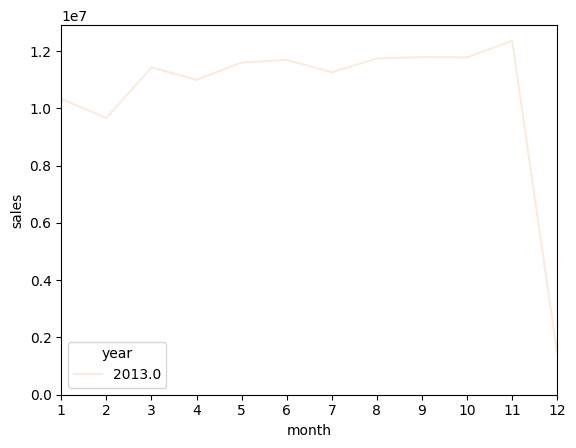

In [6]:
# Create a graph for allsales:

total_monthly_sales = original_train.groupby(['year','month']).agg({"sales" : "sum"}).reset_index()

total_monthly_sales.at[55,'sales'] = np.nan

total_plot = sns.lineplot(x='month', y='sales', hue='year', palette='rocket_r', data=total_monthly_sales)
total_plot.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
